In [1]:
import numpy as np
import tensorflow as tf
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, depolarizing_error, ReadoutError
from qiskit_ibm_provider import IBMProvider
import random
from qiskit.exceptions import QiskitError
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd
import matplotlib.ticker as ticker
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# 固定シード
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tfd = tfp.distributions

# ── 0) Qiskit Runtime Service 認証情報の登録 ───────────────────────────
# 初回だけ実行してください。token と instance はご自身の値に置き換えを。
QiskitRuntimeService.save_account(
    channel='ibm_cloud',                                   # Cloud 経由なら 'ibm_cloud'
    token='tBQFGaI8VXAKOMLBH_MFKVAS7hJY-6PYDrs9tI-whgcy',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/5fb656d927c244cf8a067bd56a1d4782:ae358d8c-5701-402f-bf07-4d12096a6705::',
    overwrite=True,
    set_as_default=True
)

/var/folders/c9/jw60jp_d42g04jdjf7qmhj9r0000gn/T/ipykernel_46936/231053502.py:7: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [2]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime import QiskitRuntimeService

# ── サービス初期化 ─────────────────────────────────────────
service      = QiskitRuntimeService()
real_backend = service.backend('ibm_brisbane')

# ── 3') 実機ベースのノイズモデルを自動生成 ────────────────────
#  T1/T2 緩和、ゲート誤差、1q リードアウト誤差 まで一括取得
base_noise_model = NoiseModel.from_backend(real_backend)

#クロストーク補正なし

# これを回路シミュレーションで使います
noise_model = base_noise_model



=== Cycle 1 ===

=== Cycle 2 ===

=== Cycle 3 ===

=== Cycle 4 ===

=== Cycle 5 ===

=== Cycle 6 ===

=== Cycle 7 ===

=== Cycle 8 ===

=== Cycle 9 ===

=== Cycle 10 ===

=== Cycle 11 ===

=== Cycle 12 ===

=== Cycle 13 ===

=== Cycle 14 ===

=== Cycle 15 ===

=== Cycle 16 ===

=== Cycle 17 ===

=== Cycle 18 ===

=== Cycle 19 ===

=== Cycle 20 ===

=== Cycle 21 ===

=== Cycle 22 ===

=== Cycle 23 ===

=== Cycle 24 ===

=== Cycle 25 ===

=== Cycle 26 ===

=== Cycle 27 ===

=== Cycle 28 ===

=== Cycle 29 ===

=== Cycle 30 ===

=== Cycle 31 ===

=== Cycle 32 ===
    Best waveform updated with reward: 0.0653
    Best waveform updated with reward: 0.7155
    Best waveform updated with reward: 0.9067
    Best waveform updated with reward: 0.9289
    Best waveform updated with reward: 0.9316

=== Cycle 33 ===

=== Cycle 34 ===

=== Cycle 35 ===

=== Cycle 36 ===

=== Cycle 37 ===

=== Cycle 38 ===

=== Cycle 39 ===

=== Cycle 40 ===

=== Cycle 41 ===

=== Cycle 42 ===

=== Cycle 43 ===

=== 

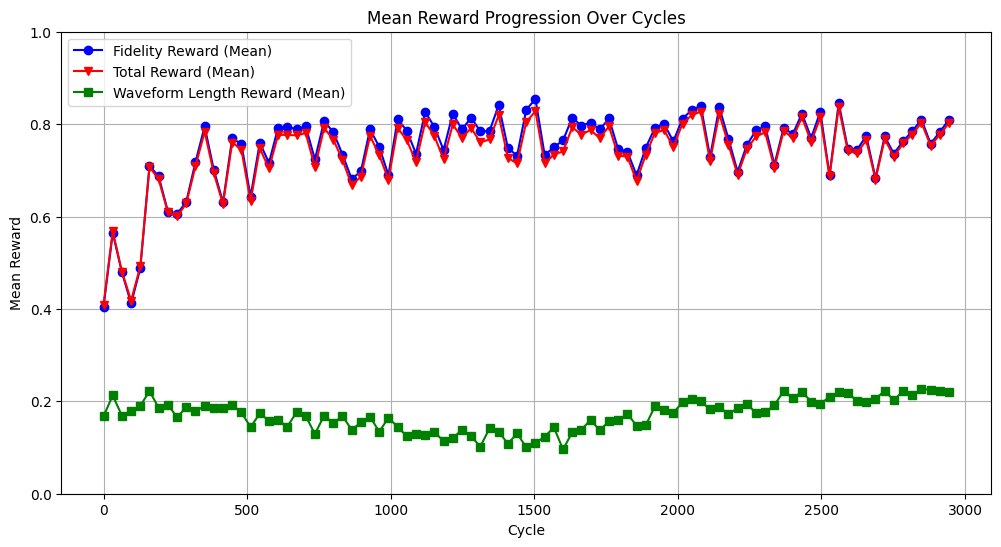

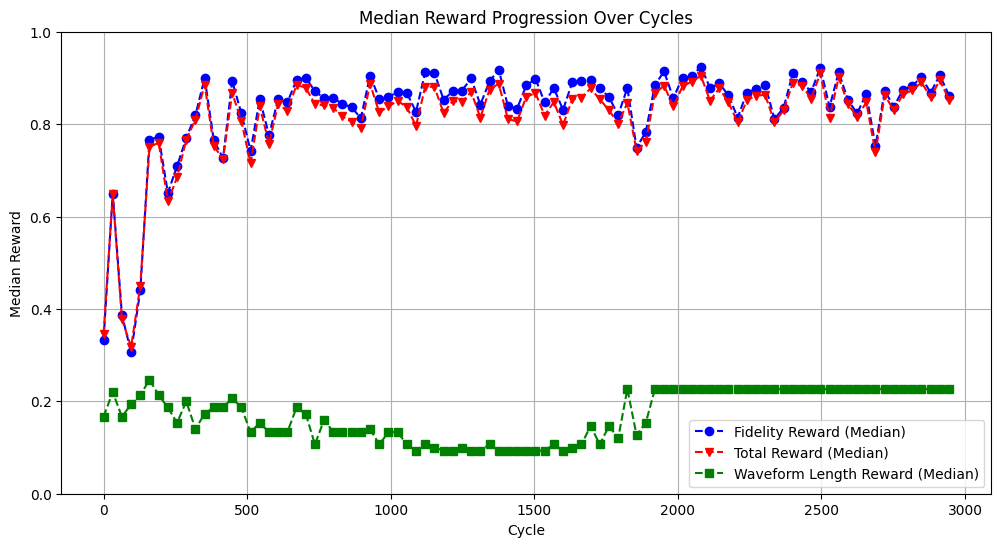

Optimized angles: theta = 3.1334, phi = -1.5954
Optimized fidelity to Rx(pi/2)|0>: 0.9985701730335348


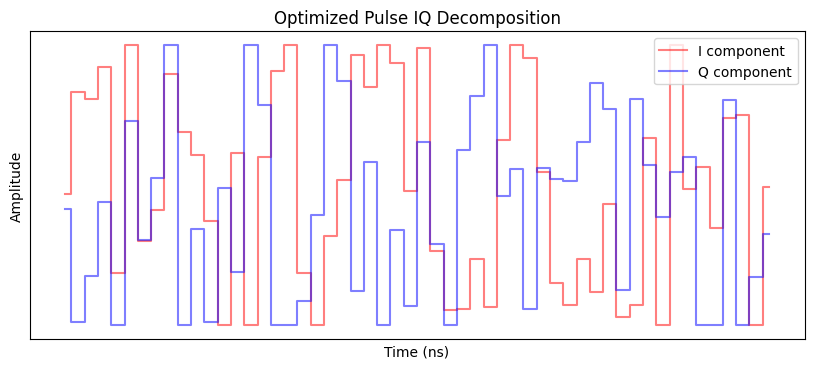

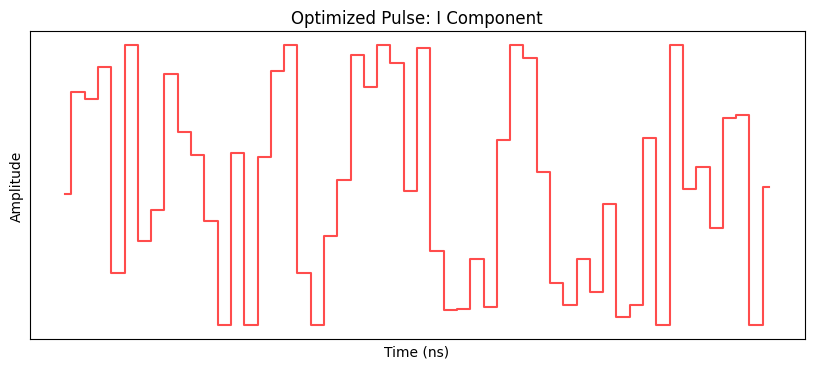

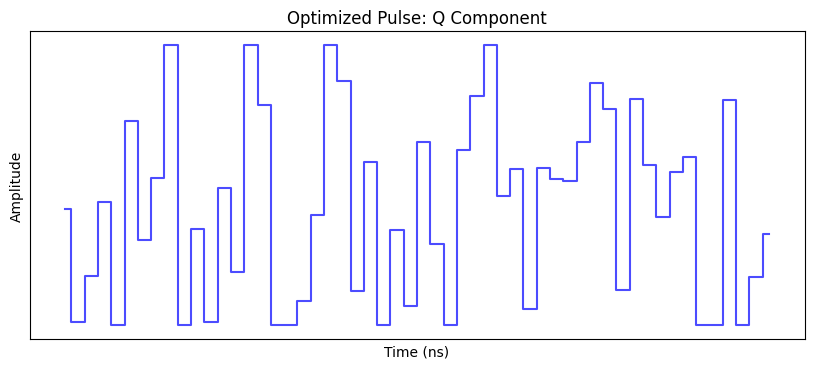

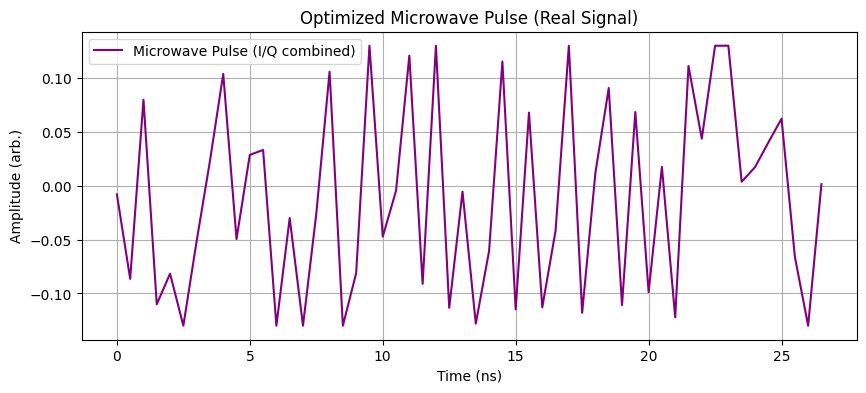

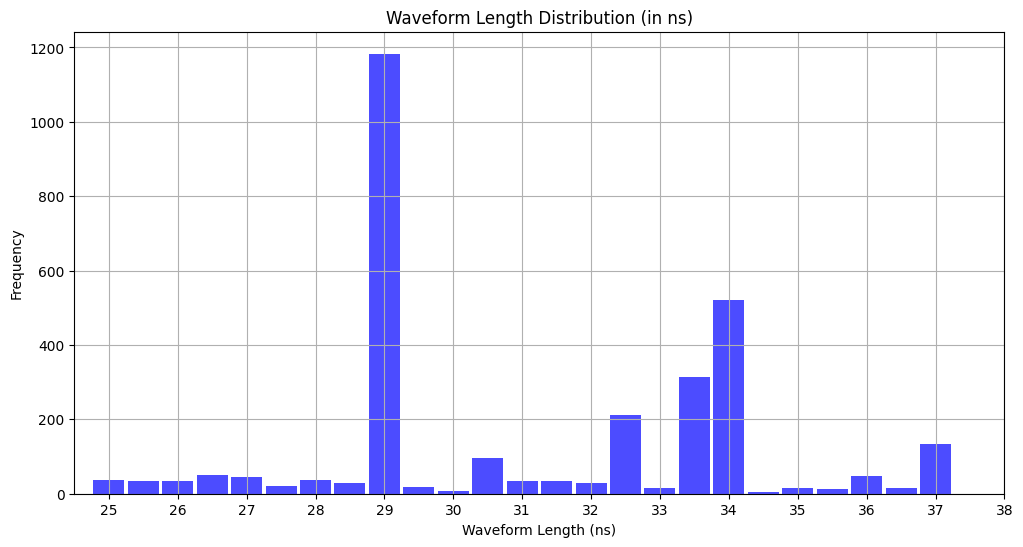

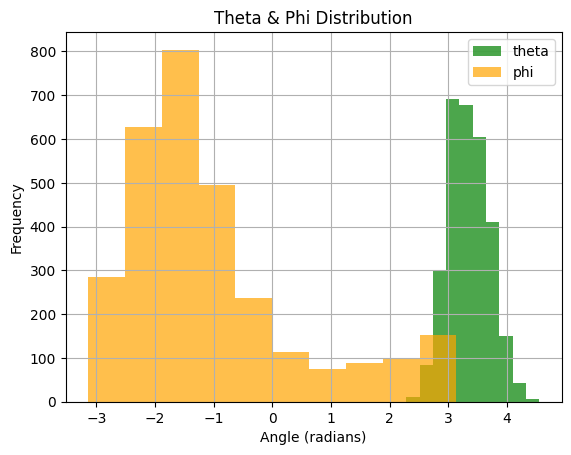

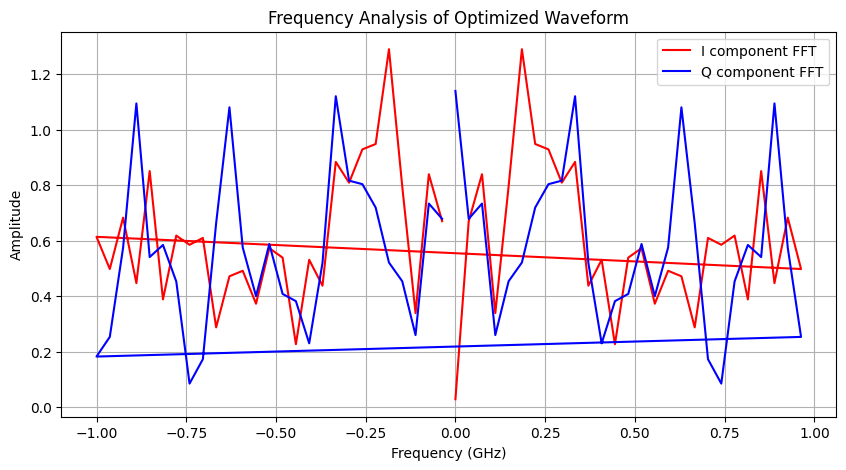

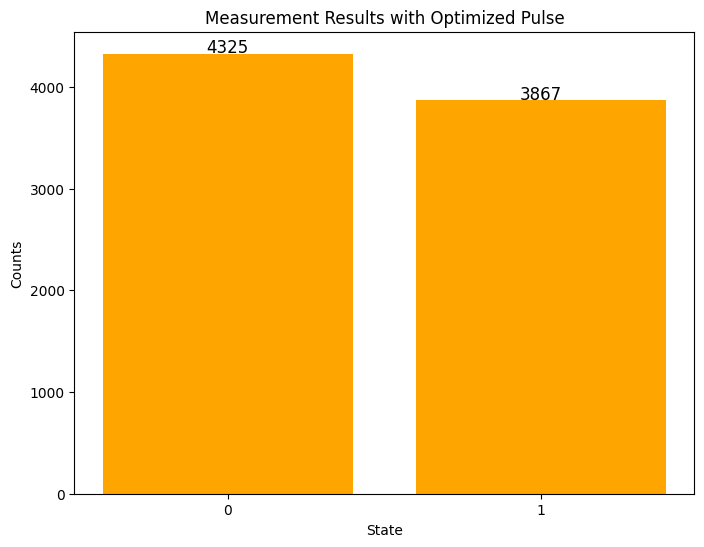

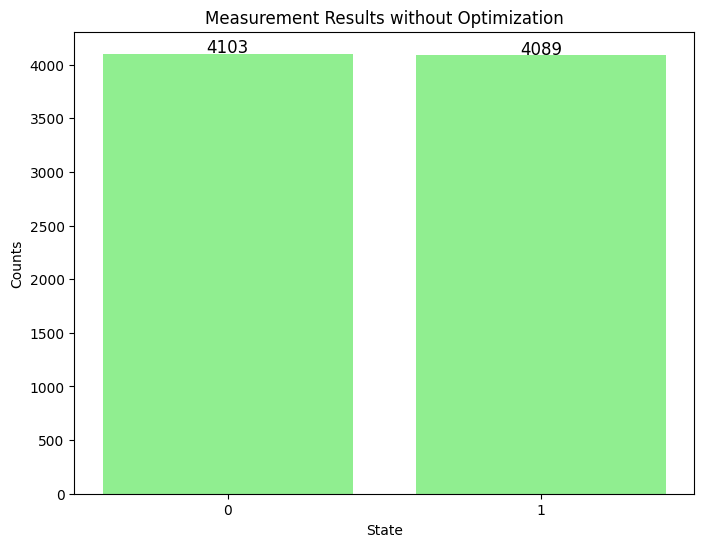

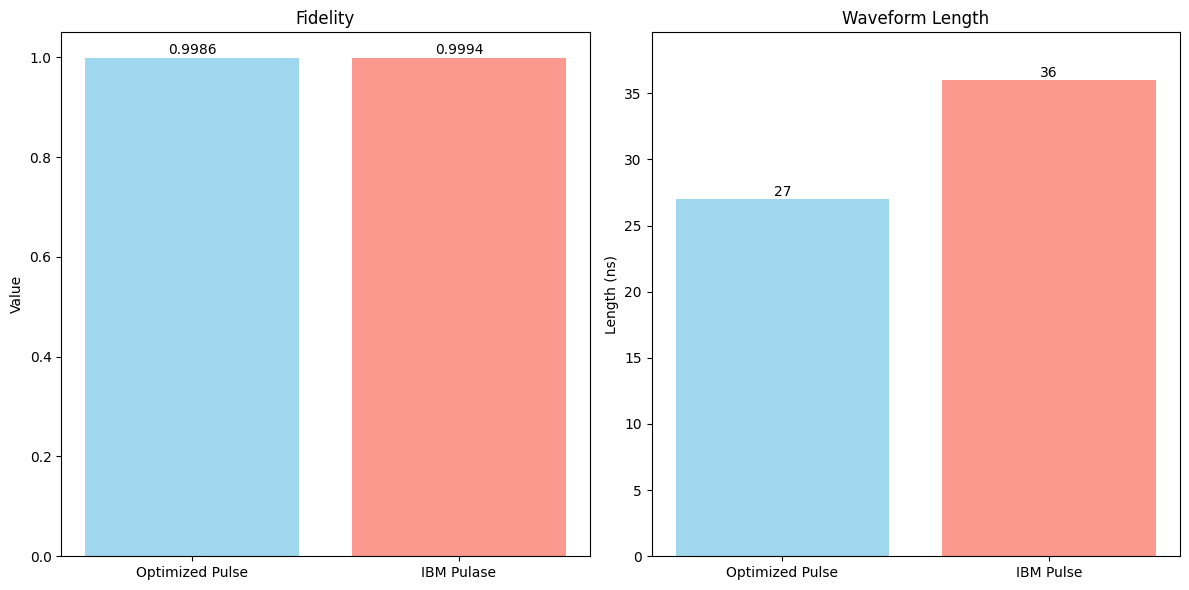

In [3]:


measurement_backend = AerSimulator(method='density_matrix', noise_model=noise_model)

def get_density_matrix(qc, backend):
    qc.save_density_matrix()
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc)
    result = job.result()
    density_matrix = np.asarray(result.data(qc)['density_matrix'])
    return density_matrix

def get_counts(qc, backend, shots=8192):
    qc.measure_all()
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

from qiskit.quantum_info import DensityMatrix, state_fidelity

def compute_fidelity_to_Rx_pi2(density_matrix_measured):
    # Rx(pi/2)|0> = (1/√2) [1, -i]
    psi_ideal = (1/np.sqrt(2)) * np.array([1, -1j])
    rho_ideal = DensityMatrix(psi_ideal)

    # 測定された密度行列をDensityMatrixオブジェクトに変換
    rho_measured = DensityMatrix(density_matrix_measured)

    # フィデリティの計算
    fidelity = state_fidelity(rho_ideal, rho_measured)

    return fidelity


def calculate_total_reward(fidelity, waveform_length, min_waveform_length, max_waveform_length):
    weights = {'fidelity': 0.95,
        'waveform_length': 0.05
    }
    normalized_length = (max_waveform_length - waveform_length) / (max_waveform_length - min_waveform_length)
    waveform_length_reward = normalized_length
    total_reward = (
        weights['fidelity'] * fidelity +
        weights['waveform_length'] * waveform_length_reward
    )
    return total_reward

def analyze_waveform_frequency(I_waveform, Q_waveform, dt=0.5):
    I_fft = np.fft.fft(I_waveform)
    Q_fft = np.fft.fft(Q_waveform)
    freqs = np.fft.fftfreq(len(I_waveform), d=dt)
    return freqs, np.abs(I_fft), np.abs(Q_fft)

def compute_angles_from_IQ(I_waveform, Q_waveform, dt=0.5):
    Omega_t = np.sqrt(I_waveform**2 + Q_waveform**2)  # 瞬時ラビ周波数
    phi_t = np.arctan2(Q_waveform, I_waveform)  # 瞬時位相

    theta = np.sum(Omega_t) * dt  # 総回転角
    theta = np.mod(theta, 2 * np.pi)  # 0から2πの範囲内に正規化

    # 全体の位相を求める
    phi = np.arctan2(np.sum(Q_waveform), np.sum(I_waveform))

    return theta, phi


class MultiObjectivePolicyGradientAgent:
    def __init__(self, state_size, min_waveform_length=50, max_waveform_length=75, initial_learning_rate=0.002):
        self.state_size = state_size
        self.min_waveform_length = min_waveform_length
        self.max_waveform_length = max_waveform_length
        self.waveform_length_range = self.max_waveform_length - self.min_waveform_length + 1
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=300,
            decay_rate=0.9,
            staircase=True
        )
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.best_waveform = None
        self.best_reward = -float('inf')
        self.model = self._build_model()

    def _build_model(self):
        initializer = tf.keras.initializers.GlorotUniform()
        model_input = tf.keras.layers.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer)(model_input)
        x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
        x = tf.keras.layers.Reshape((256, 1))(x)
        x = tf.keras.layers.LSTM(128, return_sequences=False)(x)

        waveform_param_size = 4 * self.max_waveform_length
        waveform_params = tf.keras.layers.Dense(waveform_param_size, activation='tanh', kernel_initializer=initializer)(x)
        waveform_length_logits_size = self.waveform_length_range
        waveform_length_logits = tf.keras.layers.Dense(waveform_length_logits_size, activation=None, kernel_initializer=initializer,bias_initializer='zeros')(x)

        model = tf.keras.Model(inputs=model_input, outputs=[waveform_params, waveform_length_logits])
        return model

    def generate_waveform(self, state):
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        waveform_params, waveform_length_logits = self.model(state_tensor)

        waveform_params = waveform_params[0]
        waveform_length_logits = waveform_length_logits[0]

        max_amplitude = 0.13

        waveform_length_distribution = tfd.Categorical(logits=waveform_length_logits)
        waveform_length_index = waveform_length_distribution.sample()
        waveform_length = self.min_waveform_length + waveform_length_index
        waveform_length_log_prob = waveform_length_distribution.log_prob(waveform_length_index)
        waveform_length = tf.cast(waveform_length, tf.int32)
        waveform_length_value = waveform_length.numpy()

        I_mean = max_amplitude * waveform_params[:self.max_waveform_length]
        I_std = max_amplitude * (tf.nn.softplus(waveform_params[self.max_waveform_length:2 * self.max_waveform_length]) + 1e-3)
        Q_mean = max_amplitude * waveform_params[2 * self.max_waveform_length:3 * self.max_waveform_length]
        Q_std = max_amplitude * (tf.nn.softplus(waveform_params[3 * self.max_waveform_length:4 * self.max_waveform_length]) + 1e-3)

        I_waveform_full = I_mean + I_std * tf.random.normal(I_mean.shape)
        Q_waveform_full = Q_mean + Q_std * tf.random.normal(Q_mean.shape)
        I_waveform_full = tf.clip_by_value(I_waveform_full, -max_amplitude, max_amplitude)
        Q_waveform_full = tf.clip_by_value(Q_waveform_full, -max_amplitude, max_amplitude)

        I_waveform = I_waveform_full[:waveform_length_value].numpy()
        Q_waveform = Q_waveform_full[:waveform_length_value].numpy()

        return I_waveform, Q_waveform, waveform_length_value, waveform_length_log_prob

    def compute_discounted_rewards(self, rewards, gamma=0.98):
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        cumulative = 0.0
        for t in reversed(range(len(rewards))):
            cumulative = rewards[t] + gamma * cumulative
            discounted_rewards[t] = cumulative
        return discounted_rewards

    def update_policy(self, states, rewards, gamma=0.98):
        discounted_rewards = self.compute_discounted_rewards(rewards, gamma)
        discounted_rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)
        if len(discounted_rewards) > 1:
            discounted_rewards -= tf.reduce_mean(discounted_rewards)
            discounted_rewards /= (tf.math.reduce_std(discounted_rewards) + 1e-8)

        with tf.GradientTape() as tape:
            total_log_probs = []
            state_tensors = tf.convert_to_tensor(states, dtype=tf.float32)
            waveform_params_batch, waveform_length_logits_batch = self.model(state_tensors)

            for i in range(len(states)):
                waveform_params = waveform_params_batch[i]
                waveform_length_logits = waveform_length_logits_batch[i]

                waveform_length_distribution = tfd.Categorical(logits=waveform_length_logits)
                waveform_length_index = waveform_length_distribution.sample()
                waveform_length = self.min_waveform_length + waveform_length_index
                waveform_length_log_prob = waveform_length_distribution.log_prob(waveform_length_index)
                waveform_length = tf.cast(waveform_length, tf.int32)
                waveform_length_value = waveform_length.numpy()

                I_mean = waveform_params[:self.max_waveform_length]
                I_std = tf.nn.softplus(waveform_params[self.max_waveform_length:2 * self.max_waveform_length]) + 1e-3
                Q_mean = waveform_params[2 * self.max_waveform_length:3 * self.max_waveform_length]
                Q_std = tf.nn.softplus(waveform_params[3 * self.max_waveform_length:4 * self.max_waveform_length]) + 1e-3

                I_waveform_full = I_mean[:waveform_length_value] + I_std[:waveform_length_value]*tf.random.normal(I_mean[:waveform_length_value].shape)
                Q_waveform_full = Q_mean[:waveform_length_value] + Q_std[:waveform_length_value]*tf.random.normal(Q_mean[:waveform_length_value].shape)

                I_dist = tfd.Normal(I_mean[:waveform_length_value], I_std[:waveform_length_value])
                Q_dist = tfd.Normal(Q_mean[:waveform_length_value], Q_std[:waveform_length_value])
                log_prob_I = tf.reduce_sum(I_dist.log_prob(I_waveform_full))
                log_prob_Q = tf.reduce_sum(Q_dist.log_prob(Q_waveform_full))

                total_log_prob = log_prob_I + log_prob_Q + waveform_length_log_prob
                total_log_probs.append(total_log_prob)

            total_log_probs = tf.stack(total_log_probs)
            loss = -tf.reduce_mean(discounted_rewards * total_log_probs)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        clipped_gradients = [tf.clip_by_value(grad, -5.0, 5.0) for grad in gradients if grad is not None]
        self.optimizer.apply_gradients(zip(clipped_gradients, self.model.trainable_variables))

def design_and_optimize_pulse(agent, measurement_backend, cycles=3000, batch_size=32):
    all_rewards = []
    batch_states = []
    batch_rewards = []

    fidelity_list = []
    total_reward_list = []
    waveform_length_list = []
    theta_list = []
    phi_list = []

    for cycle in range(cycles):
        print(f"\n=== Cycle {cycle + 1} ===")
        qc = QuantumCircuit(1, name='state_experiment')

        try:
            density_matrix = get_density_matrix(qc, measurement_backend)
        except QiskitError as e:
            print(f"Cycle {cycle + 1}: {e}")
            continue

        state_vector = np.concatenate([
            np.real(density_matrix).flatten(),
            np.imag(density_matrix).flatten()
        ])

        batch_states.append(state_vector)
        batch_rewards.append(0.0)

        if (cycle + 1) % batch_size == 0:
            current_batch_states = batch_states.copy()
            current_batch_rewards = []
            batch_fidelity = []
            batch_total_reward = []
            batch_waveform_length = []
            batch_theta = []
            batch_phi = []

            for state in current_batch_states:
                I_waveform, Q_waveform, waveform_length, waveform_length_log_prob = agent.generate_waveform(state)

                # I/Q波形からthetaとphi計算（クリップなし）
                theta, phi = compute_angles_from_IQ(I_waveform, Q_waveform)

                # Rx(pi/2)|0>状態との忠実度を計算
                qc = QuantumCircuit(1,1)
                qc.ry(theta, 0)
                qc.rx(phi, 0)

                try:
                    density_matrix_measured = get_density_matrix(qc, measurement_backend)
                except QiskitError as e:
                    print(f"Cycle error: {e}")
                    continue

                fidelity = compute_fidelity_to_Rx_pi2(density_matrix_measured)
                total_reward = calculate_total_reward(
                    fidelity=fidelity,
                    waveform_length=waveform_length,
                    min_waveform_length=agent.min_waveform_length,
                    max_waveform_length=agent.max_waveform_length
                )

                all_rewards.append(total_reward)
                current_batch_rewards.append(total_reward)

                if total_reward > agent.best_reward:
                    agent.best_reward = total_reward
                    agent.best_waveform = {
                        'I_waveform': I_waveform,
                        'Q_waveform': Q_waveform,
                        'theta': theta,
                        'phi': phi,
                        'reward': total_reward
                    }
                    print(f"    Best waveform updated with reward: {agent.best_reward:.4f}")

                batch_fidelity.append(fidelity)
                batch_total_reward.append(total_reward)
                batch_waveform_length.append(waveform_length)
                batch_theta.append(theta)
                batch_phi.append(phi)

            fidelity_list.extend(batch_fidelity)
            total_reward_list.extend(batch_total_reward)
            waveform_length_list.extend(batch_waveform_length)
            theta_list.extend(batch_theta)
            phi_list.extend(batch_phi)

            agent.update_policy(
                states=current_batch_states,
                rewards=current_batch_rewards
            )

            batch_states = []
            batch_rewards = []

    return (all_rewards, fidelity_list, total_reward_list, waveform_length_list, theta_list, phi_list)

def visualize_results(agent, results):
    (all_rewards, fidelity_list, total_reward_list, waveform_length_list, theta_list, phi_list) = results
    batch_size = 32
    num_batches = len(total_reward_list) // batch_size

    mean_fidelity_list = []
    median_fidelity_list = []
    mean_total_reward_list = []
    median_total_reward_list = []
    mean_waveform_length_reward_list = []
    median_waveform_length_reward_list = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        mean_fidelity = np.mean(fidelity_list[start_idx:end_idx])
        mean_total_reward = np.mean(total_reward_list[start_idx:end_idx])
        median_fidelity = np.median(fidelity_list[start_idx:end_idx])
        median_total_reward = np.median(total_reward_list[start_idx:end_idx])

        waveform_length_rewards = [1 - wl / agent.max_waveform_length for wl in waveform_length_list[start_idx:end_idx]]
        mean_waveform_length_reward = np.mean(waveform_length_rewards)
        median_waveform_length_reward = np.median(waveform_length_rewards)

        mean_fidelity_list.append(mean_fidelity)
        median_fidelity_list.append(median_fidelity)
        mean_total_reward_list.append(mean_total_reward)
        median_total_reward_list.append(median_total_reward)
        mean_waveform_length_reward_list.append(mean_waveform_length_reward)
        median_waveform_length_reward_list.append(median_waveform_length_reward)

    cycles = np.arange(num_batches) * batch_size

    # 平均報酬グラフ
    plt.figure(figsize=(12, 6))
    plt.plot(cycles, mean_fidelity_list, 'o-', color="blue", label="Fidelity Reward (Mean)")
    plt.plot(cycles, mean_total_reward_list, 'v-', color="red", label="Total Reward (Mean)")
    plt.plot(cycles, mean_waveform_length_reward_list, 's-', color="green", label="Waveform Length Reward (Mean)")
    plt.xlabel("Cycle")
    plt.ylabel("Mean Reward")
    plt.title("Mean Reward Progression Over Cycles")
    plt.legend(loc="best")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

    # 中央値報酬グラフ
    plt.figure(figsize=(12, 6))
    plt.plot(cycles, median_fidelity_list, 'o--', color="blue", label="Fidelity Reward (Median)")
    plt.plot(cycles, median_total_reward_list, 'v--', color="red", label="Total Reward (Median)")
    plt.plot(cycles, median_waveform_length_reward_list, 's--', color="green", label="Waveform Length Reward (Median)")
    plt.xlabel("Cycle")
    plt.ylabel("Median Reward")
    plt.title("Median Reward Progression Over Cycles")
    plt.legend(loc="best")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

    if agent.best_waveform is not None:
        optimized_waveform_I = agent.best_waveform['I_waveform']
        optimized_waveform_Q = agent.best_waveform['Q_waveform']
        theta_opt = agent.best_waveform['theta']
        phi_opt = agent.best_waveform['phi']
        print(f"Optimized angles: theta = {theta_opt:.4f}, phi = {phi_opt:.4f}")

        qc_opt = QuantumCircuit(1)
        qc_opt.ry(theta_opt, 0)
        qc_opt.rx(phi_opt, 0)
        density_matrix_opt = get_density_matrix(qc_opt, measurement_backend)
        fidelity_opt = compute_fidelity_to_Rx_pi2(density_matrix_opt)
        print("Optimized fidelity to Rx(pi/2)|0>:", fidelity_opt)

        waveform_length_opt = len(optimized_waveform_I)
        time_ns = np.arange(waveform_length_opt) * 0.5

        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_I, where='mid', color='red', alpha=0.5, label='I component')
        plt.step(time_ns, optimized_waveform_Q, where='mid', color='blue', alpha=0.5, label='Q component')
        plt.xlabel('Time (ns)')
        plt.ylabel('Amplitude')
        plt.title('Optimized Pulse IQ Decomposition')
        plt.xticks([])  # x軸の目盛りを消す
        plt.yticks([])  # y軸の目盛りを消す

        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        # 1. I成分のみ
        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_I, where='mid', color='red', alpha=0.7)
        plt.xlabel('Time (ns)')
        plt.ylabel('Amplitude')
        plt.title('Optimized Pulse: I Component')
        plt.xticks([])  # x軸の目盛りを消す
        plt.yticks([])  # y軸の目盛りを消す

        plt.grid(True)
        plt.show()

    # 2. Q成分のみ
        plt.figure(figsize=(10,4))
        plt.step(time_ns, optimized_waveform_Q, where='mid', color='blue', alpha=0.7)
        plt.xlabel('Time (ns)')
        plt.ylabel('Amplitude')
        plt.title('Optimized Pulse: Q Component')
        plt.xticks([])  # x軸の目盛りを消す
        plt.yticks([])  # y軸の目盛りを消す

        plt.grid(True)
        plt.show()

        # 例: ローカルオシレータ(LO)周波数を 5 GHz と仮定
        f_LO = 5.0e9  # 5 GHz
        omega_LO = 2 * np.pi * f_LO

        # 既存の dt=0.5 ns = 0.5e-9 秒 を利用
        dt_sec = 0.5e-9

        # agent.best_waveform に格納されている I_waveform, Q_waveform を取り出す
        I_waveform = agent.best_waveform['I_waveform']
        Q_waveform = agent.best_waveform['Q_waveform']
        waveform_length_opt = len(I_waveform)

        # 時間配列を作成 (0, dt_sec, 2*dt_sec, ..., (waveform_length_opt-1)*dt_sec)
        t_array = np.arange(waveform_length_opt) * dt_sec

        # 合成 (実部信号)
        microwave_signal = I_waveform * np.cos(omega_LO * t_array) - Q_waveform * np.sin(omega_LO * t_array)

        # グラフ描画
        plt.figure(figsize=(10,4))
        plt.plot(t_array*1e9, microwave_signal, color='purple', label='Microwave Pulse (I/Q combined)')
        plt.xlabel("Time (ns)")
        plt.ylabel("Amplitude (arb.)")
        plt.title("Optimized Microwave Pulse (Real Signal)")
        plt.grid(True)
        plt.legend()
        plt.show()
        
        waveform_length_ns = [length * 0.5 for length in waveform_length_list]
        min_len = min(waveform_length_ns)
        max_len = max(waveform_length_ns)
        bin_edges = np.arange(24.5, 38, 0.5)
        plt.figure(figsize=(12,6))
        plt.hist(waveform_length_ns, bins=bin_edges,align='left',color='blue', alpha=0.7, rwidth=0.9)
        plt.title("Waveform Length Distribution (in ns)")
        plt.xlabel("Waveform Length (ns)")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.xlim(24.5, 38)

        # x軸を0.5刻みに整える
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        plt.show()
     

        plt.hist(theta_list, bins=10, color='green', alpha=0.7, label='theta')
        plt.hist(phi_list, bins=10, color='orange', alpha=0.7, label='phi')
        plt.title("Theta & Phi Distribution")
        plt.xlabel("Angle (radians)")
        plt.ylabel("Frequency")
        plt.grid()
        plt.legend()
        plt.show()

        freqs, I_fft_abs, Q_fft_abs = analyze_waveform_frequency(optimized_waveform_I, optimized_waveform_Q)
        plt.figure(figsize=(10, 5))
        plt.plot(freqs, I_fft_abs, label="I component FFT", color="red")
        plt.plot(freqs, Q_fft_abs, label="Q component FFT", color="blue")
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Amplitude")
        plt.title("Frequency Analysis of Optimized Waveform")
        plt.legend()
        plt.grid(True)
        plt.show()

        counts_opt = get_counts(qc_opt, measurement_backend, shots=8192)
        states_opt = ['0', '1']
        counts_plot_opt = [counts_opt.get('0', 0), counts_opt.get('1', 0)]
        plt.figure(figsize=(8,6))
        bars_opt = plt.bar(states_opt, counts_plot_opt, color='orange')
        plt.xlabel('State')
        plt.ylabel('Counts')
        plt.title('Measurement Results with Optimized Pulse')
        for bar in bars_opt:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, f'{int(yval)}', ha='center', fontsize=12)
        plt.show()
    else:
        print("No optimized waveform available to visualize.")

    # 非最適化比較用 (例としてRx(pi/2)ゲートを理想的に適用)
    qc_no_opt = QuantumCircuit(1)
    qc_no_opt.rx(np.pi/2, 0)
    density_matrix_no_opt = get_density_matrix(qc_no_opt, measurement_backend)
    fidelity_no_opt = compute_fidelity_to_Rx_pi2(density_matrix_no_opt)
    waveform_length_no_opt = 36

    counts_no_opt = get_counts(qc_no_opt, measurement_backend, shots=8192)
    counts_plot_no_opt = [counts_no_opt.get('0', 0), counts_no_opt.get('1', 0)]
    states_no_opt = ['0', '1']

    plt.figure(figsize=(8, 6))
    bars_no_opt = plt.bar(states_no_opt, counts_plot_no_opt, color='lightgreen')
    plt.xlabel('State')
    plt.ylabel('Counts')
    plt.title('Measurement Results without Optimization')
    for bar in bars_no_opt:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{int(yval)}', ha='center', fontsize=12)
    plt.show()

    if agent.best_waveform is not None:
        optimized_values = [fidelity_opt, waveform_length_opt*0.5]
    else:
        optimized_values = [0, 0]
    non_optimized_values = [fidelity_no_opt, waveform_length_no_opt]

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    def autolabel(rects, ax, fmt='{:.4f}'):
        for rect in rects:
            height = rect.get_height()
            label = fmt.format(height) if isinstance(height, float) else str(height)
            ax.text(rect.get_x() + rect.get_width() / 2., height + 0.001, 
                    label, ha='center', va='bottom', fontsize=10)

    bars_fid = axs[0].bar(['Optimized Pulse', 'IBM Pulase'], 
                           [optimized_values[0], non_optimized_values[0]], 
                           color=['skyblue', 'salmon'], alpha=0.8)
    axs[0].set_title('Fidelity')
    axs[0].set_ylabel('Value')
    axs[0].set_ylim(0.00, 1.05)
    autolabel(bars_fid, axs[0])

    bars_len = axs[1].bar(['Optimized Pulse', 'IBM Pulse'], 
                           [optimized_values[1], non_optimized_values[1]], 
                           color=['skyblue', 'salmon'], alpha=0.8)
    axs[1].set_title('Waveform Length')
    axs[1].set_ylabel('Length (ns)')
    axs[1].set_ylim(0, max(optimized_values[1], non_optimized_values[1]) * 1.1)
    autolabel(bars_len, axs[1], fmt='{:.0f}')

    plt.tight_layout()
    plt.show()

# 実行
state_size = 8
agent = MultiObjectivePolicyGradientAgent(
    state_size=state_size,
    min_waveform_length=50,
    max_waveform_length=75,
    initial_learning_rate=0.003
)

results = design_and_optimize_pulse(agent, measurement_backend, cycles=3000, batch_size=32)
(all_rewards, fidelity_list, total_reward_list, waveform_length_list, theta_list, phi_list) = results
visualize_results(agent, results)
